# Card Images Classification

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.utils import shuffle

import cv2


import matplotlib.image as mpimg
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage import data, color, io, filters, morphology,transform, exposure, feature, util
from scipy import ndimage

from sklearn.preprocessing import StandardScaler
import seaborn as sns



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization,concatenate
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras import backend as K
from tensorflow.python.keras.layers.core import Dropout, Lambda
from tensorflow.python.keras.layers.core import * 
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions


import glob


from tensorflow.keras.callbacks import *
# Voor GPU support
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

pd.set_option('display.max_rows',10000)
pd.set_option('display.max_columns',10000)

### 1) problem understanding
I need to classify cards


### 2) data import

In [2]:
batch_size = 32
img_height = 200
img_width = 200

In [3]:
train_folder="./dataset/train"
# will automatically label the images based on the folder structure 
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_folder,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


class_names_train = train_ds.class_names
class_names_train

Found 7624 files belonging to 53 classes.


['ace of clubs',
 'ace of diamonds',
 'ace of hearts',
 'ace of spades',
 'eight of clubs',
 'eight of diamonds',
 'eight of hearts',
 'eight of spades',
 'five of clubs',
 'five of diamonds',
 'five of hearts',
 'five of spades',
 'four of clubs',
 'four of diamonds',
 'four of hearts',
 'four of spades',
 'jack of clubs',
 'jack of diamonds',
 'jack of hearts',
 'jack of spades',
 'joker',
 'king of clubs',
 'king of diamonds',
 'king of hearts',
 'king of spades',
 'nine of clubs',
 'nine of diamonds',
 'nine of hearts',
 'nine of spades',
 'queen of clubs',
 'queen of diamonds',
 'queen of hearts',
 'queen of spades',
 'seven of clubs',
 'seven of diamonds',
 'seven of hearts',
 'seven of spades',
 'six of clubs',
 'six of diamonds',
 'six of hearts',
 'six of spades',
 'ten of clubs',
 'ten of diamonds',
 'ten of hearts',
 'ten of spades',
 'three of clubs',
 'three of diamonds',
 'three of hearts',
 'three of spades',
 'two of clubs',
 'two of diamonds',
 'two of hearts',
 'two o

In [4]:
validation_folder="./dataset/valid"
val_ds = tf.keras.utils.image_dataset_from_directory(
  validation_folder,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


class_names_val = val_ds.class_names

Found 265 files belonging to 53 classes.


#### 2.1) Configure the Dataset for Performance
To make sure that data loading does not become a bottleneck during training, use buffered prefetching. This can be easily done in TensorFlow:

In [5]:

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


#### 3) Visualize the data


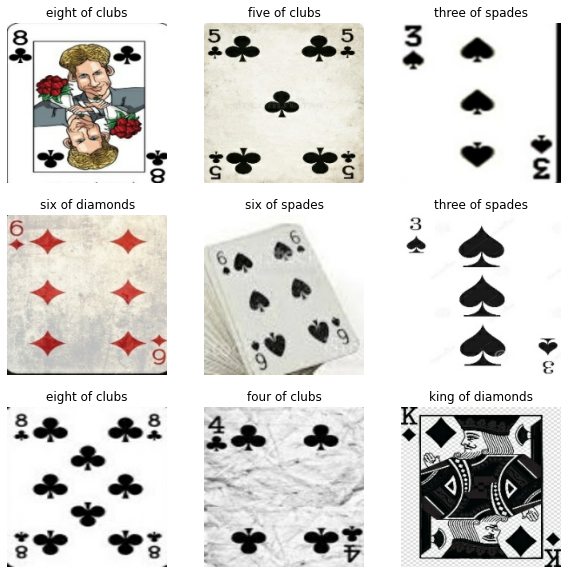

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names_train[labels[i]])
        plt.axis("off")

code or find a library that checks  Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ..

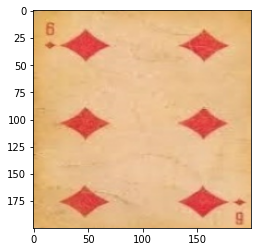

In [7]:
plt.imshow(images[10].numpy().astype("uint8"))


#### 3) class distribution 

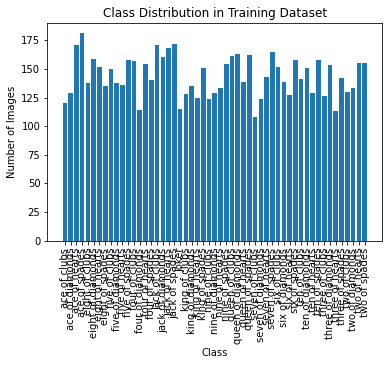

In [40]:
class_counts = {classname: 0 for classname in class_names_train}

for images, labels in train_ds:
    for label in labels:
        label_name = class_names_train[label]
        class_counts[label_name] += 1

plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Dataset')
plt.show()


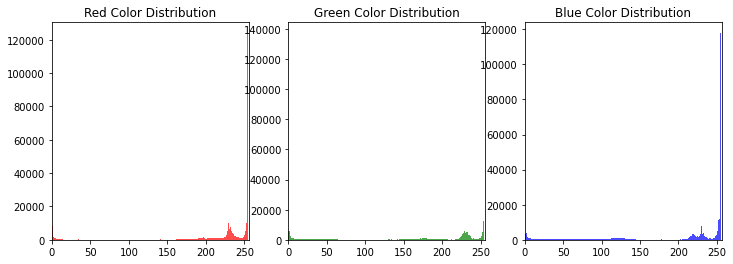

In [43]:
# Function to plot color histograms
def plot_color_histograms(image_batch):
    plt.figure(figsize=(12, 4))
    for i in range(3):  # RGB channels
        channel_data = image_batch[:, :, :, i].numpy().flatten()
        if i == 0:
            color = 'red'
        elif i == 1:
            color = 'green'
        else:
            color = 'blue'
        plt.subplot(1, 3, i + 1)
        plt.hist(channel_data, bins=256, color=color, alpha=0.7)
        plt.title(f'{color.capitalize()} Color Distribution')
        plt.xlim([0, 256])
    plt.show()

# Extract the first batch of images
for image_batch, _ in train_ds.take(1):
    break

# Plot color histograms for the first batch
plot_color_histograms(image_batch)

### 4.) Data Normalization
normalize the image data to have pixel values between 0 and 1 for better model performance.

In [8]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


### 5.) Model 
I' am going to use a pre trainend model (ResNet50) so i dont lose time creating and training one.  



In [13]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Model checkpoint path with epoch number
checkpoint_filepath = './model_epoch_{epoch:02d}.h5'

# Early stopping (val_loss used when you want to minimize the error or loss function)
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath,save_weights_only=True, monitor='val_loss',mode='auto',save_best_only=True)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)


# load the pre trainend model on ImageNet
# not including the top, bcs its trained on imagenet dataset
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

for layer in base_model.layers:
    layer.trainable = False


# Data augmentation
data_augmentation_layers = Sequential([
    tf.keras.layers.Rescaling(1./255),  # Rescale pixel values to [0, 1]
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
])

# Freeze the base model (data augmentation)
base_model.trainable = False


# Define the classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x) #L2
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Specify the number of classes in your training dataset
num_classes = len(class_names_train)

predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


In [14]:
# Learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [15]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [17]:
history = model.fit(train_ds, validation_data=val_ds, epochs=5, verbose=1,callbacks=[es,mc])

Epoch 1/5


239/239 [==============================] - 14s 58ms/step - loss: 2.2154 - accuracy: 0.5291 - val_loss: 2.1875 - val_accuracy: 0.5321
Epoch 2/5
239/239 [==============================] - 14s 57ms/step - loss: 2.1985 - accuracy: 0.5316 - val_loss: 2.1322 - val_accuracy: 0.5472
Epoch 3/5
239/239 [==============================] - 14s 57ms/step - loss: 2.1895 - accuracy: 0.5325 - val_loss: 2.1899 - val_accuracy: 0.5321
Epoch 4/5
239/239 [==============================] - 14s 57ms/step - loss: 2.1739 - accuracy: 0.5349 - val_loss: 2.6334 - val_accuracy: 0.4189
Epoch 5/5
239/239 [==============================] - 13s 56ms/step - loss: 2.1775 - accuracy: 0.5425 - val_loss: 2.1833 - val_accuracy: 0.5094


In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

### 6.) Model evaluation 


Best Epoch (Loss): 3


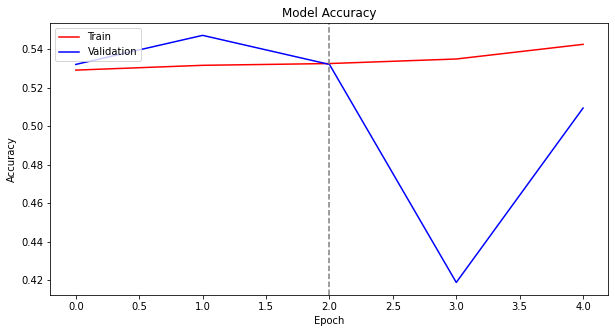

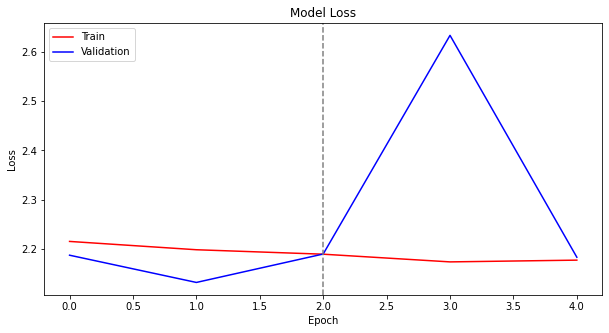

In [29]:
# Plot history
# Check for underfitting / overfitting based on the model loss history
# Determine the optimal number of training epochs. Use early stopping with model checkpoint saving. rezftre


# Assuming 'history' is the object returned by model.fit()

# Find the index of the lowest validation loss, (epochs are zero-indexed so add 1)
best_epoch_loss = np.argmin(history.history['val_loss']) + 1

# Print the best epoch number (epochs are zero-indexed so add 1)
print(f"Best Epoch (Loss): {best_epoch_loss + 1}")

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], 'r')
plt.plot(history.history['val_accuracy'], 'b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
# Annotate the best epoch in the accuracy plot
plt.axvline(x=best_epoch_loss, color='gray', linestyle='--')

plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
# Annotate the best epoch in the loss plot
plt.axvline(x=best_epoch_loss, color='gray', linestyle='--')

plt.show()

my model is overfitting:

Steps:

- 1) data augmentation (x) 
- 2) regularization, dropout or l2
- 3) reduce model complexity, layers, neurons
- 4) earlystopping
- 5) adjust learning rate

In [20]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize lists to store true labels and predictions
y_true = []
y_pred = []

# Iterate over the validation dataset and store true labels and predictions
for images, labels in val_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=-1))
    y_true.extend(labels.numpy())

# Calculate and print the classification report
print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=class_names_val))

# Calculate and print the confusion matrix
cf = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(cf)

# Calculate and print the accuracy
acc = accuracy_score(y_true, y_pred) * 100
print(f'Accuracy: {acc}%')



Classification Report:
                   precision    recall  f1-score   support

     ace of clubs       0.50      0.40      0.44         5
  ace of diamonds       1.00      0.60      0.75         5
    ace of hearts       0.50      0.60      0.55         5
    ace of spades       0.56      1.00      0.71         5
   eight of clubs       0.00      0.00      0.00         5
eight of diamonds       0.19      0.80      0.31         5
  eight of hearts       0.29      0.80      0.42         5
  eight of spades       0.80      0.80      0.80         5
    five of clubs       0.00      0.00      0.00         5
 five of diamonds       0.60      0.60      0.60         5
   five of hearts       1.00      0.20      0.33         5
   five of spades       0.67      0.40      0.50         5
    four of clubs       0.22      0.40      0.29         5
 four of diamonds       0.67      0.40      0.50         5
   four of hearts       1.00      0.60      0.75         5
   four of spades       1.00   

c:\Users\ouassim boutalliss\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ouassim boutalliss\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ouassim boutalliss\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

We kunnen heel snel zien met welke classes mijn model sukkelt

### .7) model understanding 


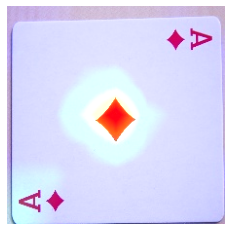

In [39]:
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')  # Ensure the image is uint8

    cv2.imwrite(cam_path, superimposed_img)

    display_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    plt.imshow(display_img)
    plt.axis('off')

# Prepare image
img_path = './Dataset/train/ace of diamonds/001.jpg'

img_array = get_img_array(img_path, size=(200, 200))  # Adjust the image size

# Generate class activation heatmap
last_conv_layer_name = "conv5_block3_out"  # Replace with your actual last convo layer name
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
save_and_display_gradcam(img_path, heatmap)


With this i can see where the model is looking at to classify the cards 